# Figures

Reproducing the `GQA-paper` figures as described in the `ReadMe.md`.

In [3]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from collections import Counter
import argparse
from tqdm import tqdm
from scipy.special import rel_entr
import plotly.express as px
import matplotlib.pyplot as plt

## Loading GQA

In [4]:
gqa_data_path = Path('ver1.2/')

# balanced questions
gqa_train_balanced_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('train_' + 'balanced_' + 'questions.json'))))).T
gqa_val_balanced_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('val_' + 'balanced_' + 'questions.json'))))).T
gqa_testdev_balanced_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('testdev_' + 'balanced_' + 'questions.json'))))).T

gqa_testdev_balanced_questions_test = json.load(open(Path(gqa_data_path / ('testdev_' + 'balanced_' + 'questions.json'))))

# all questions
gqa_train_all_questions_file_paths = [file for file in Path(gqa_data_path / 'train_all_questions').glob('*.json')]
gqa_train_all_questions = pd.DataFrame(json.load(open(gqa_train_all_questions_file_paths[0]))).T
for file in gqa_train_all_questions_file_paths[1:]:
    gqa_train_all_questions = pd.concat([gqa_train_all_questions, pd.DataFrame(json.load(open(file))).T])
gqa_val_all_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('val_' + 'all_' + 'questions.json'))))).T
gqa_testdev_all_questions = pd.DataFrame(json.load(open(Path(gqa_data_path / ('testdev_' + 'all_' + 'questions.json'))))).T

gqa_val_all_questions_test = json.load(open(Path(gqa_data_path / ('val_' + 'all_' + 'questions.json'))))

Now concat all the dataframes with the relevant columns, and compute the question length and the semantic composition length.

In [5]:
gqa_train_balanced_questions['datasplit'] = 'train'
gqa_val_balanced_questions['datasplit'] = 'val'
gqa_testdev_balanced_questions['datasplit'] = 'testdev'

gqa_train_all_questions['datasplit'] = 'train'
gqa_val_all_questions['datasplit'] = 'val'
gqa_testdev_all_questions['datasplit'] = 'testdev'

In [6]:
# for balanced:
gqa_questions_balanced_raw = pd.concat([gqa_train_balanced_questions,
                                        gqa_val_balanced_questions,
                                        gqa_testdev_balanced_questions])[['question', 'answer', 'types', 'semantic', 'datasplit']]

questionIDs_balanced = list(gqa_questions_balanced_raw.index)
gqa_questions_balanced = pd.DataFrame(columns=['questionID', 'question_text', 'answer_text',
                                            'semantic_type', 'structural_type', 'detailed_type', 'datasplit',
                                            'question_length', 'composition_len_semantic'],
                                 index = questionIDs_balanced)

gqa_questions_balanced.loc[slice(None),'questionID'] = gqa_questions_balanced_raw.index.values
gqa_questions_balanced.loc[slice(None),'question_text'] = gqa_questions_balanced_raw['question']
gqa_questions_balanced.loc[slice(None),'answer_text'] = gqa_questions_balanced_raw['answer']
gqa_questions_balanced.loc[slice(None),'semantic_type'] = gqa_questions_balanced_raw['types'].apply(lambda x: x['semantic'])
gqa_questions_balanced.loc[slice(None),'structural_type'] = gqa_questions_balanced_raw['types'].apply(lambda x: x['structural'])
gqa_questions_balanced.loc[slice(None),'detailed_type'] = gqa_questions_balanced_raw['types'].apply(lambda x: x['detailed'])
gqa_questions_balanced.loc[slice(None),'datasplit'] = gqa_questions_balanced_raw['datasplit']

# compute statistics
gqa_questions_balanced.loc[slice(None),'question_length'] = gqa_questions_balanced_raw['question'].apply(lambda x: len(re.findall(r'\w+', x)))
gqa_questions_balanced.loc[slice(None),'composition_len_semantic'] = gqa_questions_balanced_raw['semantic'].apply(lambda x: len(x))

In [7]:
# for all:
gqa_questions_all_raw = pd.concat([gqa_train_all_questions,
                                   gqa_val_all_questions,
                                   gqa_testdev_all_questions])[['question', 'answer', 'types', 'semantic', 'datasplit']]

questionIDs_all = list(gqa_questions_all_raw.index)
gqa_questions_all = pd.DataFrame(columns=['questionID', 'question_text', 'answer_text',
                                          'semantic_type', 'structural_type', 'detailed_type', 'datasplit',
                                          'question_length', 'composition_len_semantic'],
                                 index = questionIDs_all)

gqa_questions_all.loc[slice(None),'questionID'] = gqa_questions_all_raw.index.values
gqa_questions_all.loc[slice(None),'question_text'] = gqa_questions_all_raw['question']
gqa_questions_all.loc[slice(None),'answer_text'] = gqa_questions_all_raw['answer']
gqa_questions_all.loc[slice(None),'semantic_type'] = gqa_questions_all_raw['types'].apply(lambda x: x['semantic'])
gqa_questions_all.loc[slice(None),'structural_type'] = gqa_questions_all_raw['types'].apply(lambda x: x['structural'])
gqa_questions_all.loc[slice(None),'detailed_type'] = gqa_questions_all_raw['types'].apply(lambda x: x['detailed'])
gqa_questions_all.loc[slice(None),'datasplit'] = gqa_questions_all_raw['datasplit']

# compute statistics
gqa_questions_all.loc[slice(None),'question_length'] = gqa_questions_all_raw['question'].apply(lambda x: len(re.findall(r'\w+', x)))
gqa_questions_all.loc[slice(None),'composition_len_semantic'] = gqa_questions_all_raw['semantic'].apply(lambda x: len(x))

In [8]:
gqa_questions_balanced

,questionID,question_text,answer_text,semantic_type,structural_type,detailed_type,datasplit,question_length,composition_len_semantic
02930152,02930152,Is the sky dark?,yes,attr,verify,verifyAttr,train,4,2
07333408,07333408,What is on the white wall?,pipe,rel,query,relS,train,6,4
07333405,07333405,Is that pipe red?,no,attr,verify,verifyAttrC,train,4,2
15736264,15736264,Is the tall clock small or large?,large,attr,choose,chooseAttr,train,7,3
111007521,111007521,Who is wearing a shirt?,girl,rel,query,relS,train,5,3
...,...,...,...,...,...,...,...,...,...
20341099,20341099,Is there a fire hydrant on the grass?,yes,rel,verify,existRelS,testdev,8,3
20341098,20341098,Where is the fire hydrant?,grass,rel,query,relO,testdev,5,3
20341097,20341097,Where is that fire hydrant?,grass,rel,query,relO,testdev,5,3
20602949,20602949,What is the horse running across?,ground,rel,query,relO,testdev,6,3


### Testing the loading

In [ ]:
# test whether all worked out as intended, with the testdev for balanced and val for all


In [10]:
# check it for a random question from train: 05427356
print(f"qid: 05427356")
for key, value in gqa_train_balanced_questions['05427356'].items():
    print(key, value)
print("-----------------")
print(gqa_question_stats.loc['05427356'])

qid: 05427356
semantic [{'operation': 'select', 'dependencies': [], 'argument': 'person (507546)'}, {'operation': 'filter face expression', 'dependencies': [0], 'argument': 'happy'}, {'operation': 'choose rel', 'dependencies': [1], 'argument': 'backpack,to the right of|to the left of,s (507548)'}]
entailed ['05427355', '05427354', '05427357', '05427351', '05427350', '05427353', '05427352']
equivalent ['05427356']
question Is the black backpack to the right or to the left of the happy person?
imageId 2388930
isBalanced True
groups {'global': None, 'local': '13-man_backpack'}
answer right
semanticStr select: person (507546)->filter face expression: happy [0]->choose rel: backpack,to the right of|to the left of,s (507548) [1]
annotations {'answer': {}, 'question': {'2:4': '507548', '13:15': '507546'}, 'fullAnswer': {'1': '507548', '8': '507546'}}
types {'detailed': 'relChooser', 'semantic': 'rel', 'structural': 'choose'}
fullAnswer The backpack is to the right of the man.
----------------

In [11]:
# check it for a random question from val: 11875206
print(f"qid: 11875206")
for key, value in gqa_val_balanced_questions['11875206'].items():
    print(key, value)
print("-----------------")
print(gqa_question_stats.loc['11875206'])


qid: 11875206
semantic [{'operation': 'select', 'dependencies': [], 'argument': 'furniture (508648)'}, {'operation': 'query', 'dependencies': [0], 'argument': 'name'}]
entailed ['11875190', '11875207']
equivalent ['11875206']
question What is the piece of furniture in this photo called?
imageId 2388539
isBalanced True
groups {'global': 'furniture', 'local': '11q-furniture'}
answer chair
semanticStr select: furniture (508648)->query: name [0]
annotations {'answer': {'0': '508648'}, 'question': {'3:6': '508648'}, 'fullAnswer': {'1:4': '508648', '6': '508648'}}
types {'detailed': 'category', 'semantic': 'cat', 'structural': 'query'}
fullAnswer The piece of furniture is a chair.
-----------------
questionID                                                           11875206
question_text               What is the piece of furniture in this photo c...
answer_text                                                             chair
semantic_type                                                   

In [12]:
# check it for a random question from testdev: 20602949
print(f"qid: 20602949")
for key, value in gqa_testdev_balanced_questions['20602949'].items():
    print(key, value)
print("-----------------")
print(gqa_question_stats.loc['20602949'])

qid: 20602949
semantic [{'operation': 'select', 'dependencies': [], 'argument': 'horse (0)'}, {'operation': 'relate', 'dependencies': [0], 'argument': '_,running across,o (10)'}, {'operation': 'query', 'dependencies': [1], 'argument': 'name'}]
entailed ['20602947', '20602946', '20602948']
equivalent ['20602949']
question What is the horse running across?
imageId n168412
isBalanced True
groups {'global': 'nature environment', 'local': '14-horse_running across,o'}
answer ground
semanticStr select: horse (0)->relate: _,running across,o (10) [0]->query: name [1]
annotations {'answer': {'0': '10'}, 'question': {}, 'fullAnswer': {'1': '0', '6': '10'}}
types {'detailed': 'relO', 'semantic': 'rel', 'structural': 'query'}
fullAnswer The horse is running across the ground.
-----------------
questionID                                           20602949
question_text               What is the horse running across?
answer_text                                            ground
semantic_type         

## Reproducing figure 7: First Question Words (ReadMe: 1.)

In [ ]:
# create a dataframe for the sunburst diagram: first words, then their corresponding value up to a cut-off
# the cut-off is 0.1% of the total number of questions

# extract the first four words from the question_text
gqa_question_stats['first_four_words'] = gqa_question_stats['question_text'].str.split().apply(lambda x: ' '.join(x[:4]))

# count occurences
word_counts = gqa_question_stats['first_four_words'].value_counts().reset_index()
word_counts.columns = ['first_four_words', 'count']

word_counts

In [ ]:
# create a new dataframe with the necessary info
sunburst_df = pd.DataFrame(columns=['first_words', 'second_words', 'third_words', 'fourth_words', 'count'])

cutoff = 0.001 * len(gqa_question_stats)
# word_counts_filtered = word_counts[word_counts['count'] > cutoff]

# use apply to speed it up
sunburst_df['first_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[0])
sunburst_df['second_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[1])
sunburst_df['third_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[2])
sunburst_df['count']    = word_counts['count']
sunburst_df['fourth_words'] = word_counts['first_four_words'].apply(lambda x: x.split()[3] if len(x.split()) >= 4  else "")

# set the fourth_word to None if the count is below the cutoff
sunburst_df.loc[sunburst_df['count'] < cutoff, 'fourth_words'] = ""

# # set the third_word to None if the count is below the cutoff and the fourth_word is None
# sunburst_df.loc[sunburst_df['fourth_words'].isna() & (sunburst_df['count'] < cutoff), 'third_words'] = None

# # set the second_word to None if the count is below the cutoff and the third_word is None
# sunburst_df.loc[sunburst_df['third_words'].isna() & (sunburst_df['count'] < cutoff), 'second_words'] = None

In [ ]:
print(f"The sunburst diagram dataframe has {sunburst_df.shape[0]} entries with a count sum of {sunburst_df['count'].sum()}")

In [ ]:
# aggregate the count of the duplicate entries and drop the duplicates
sunburst_df_cleared = sunburst_df.groupby(['first_words', 'second_words', 'third_words', 'fourth_words'])['count'].sum().reset_index()
sunburst_df_cleared.drop_duplicates(inplace=True, keep='first')
print(f"The sunburst diagram dataframe has {len(sunburst_df_cleared)} entries with a count sum of {sunburst_df_cleared['count'].sum()}")
sunburst_df_cleared

In [ ]:
# reduce the size of the dataframe by removing all entries with a count below 5
sunburst_df_heuristic = sunburst_df_cleared[sunburst_df_cleared['count'] > 5]
print(f"The sunburst diagram dataframe has {len(sunburst_df_heuristic)} entries with a count sum of {sunburst_df_heuristic['count'].sum()}")
print(f"We are loosing the following percentage of the data: {(1 - len(sunburst_df_heuristic) / len(sunburst_df_cleared)) * 100:.2f}%")
print(f"With the following percentage of the count: {(1 - sunburst_df_heuristic['count'].sum() / sunburst_df_cleared['count'].sum()) * 100:.2f}%")

In [ ]:
# for all values below the cutoff, go even back further and sum up the counts for the first two words
fig = px.sunburst(sunburst_df_heuristic, path=['first_words', 'second_words', 'third_words', 'fourth_words'], values='count')

In [ ]:
fig.write_html('results/sunburst_diagram.html')

The rendering is super complicated and I'm too stupid to make it with those empty columns. So, I just cut the unimportant questions with not much weight, such that the qualitative view should stay the same!

The figure is super different, e.g. let's look at whether `what is the` is followed most often by `color` (supplemental) or `man`. Or more differently, whether `is` is followed by 4.5x as many `the` as `there`, or that `there` is more frequent. Or whether all `are` are followed by `there` or also by `the`.

In [ ]:
# check: whether `what is the` is followed most often by `color` (supplemental) or `man`
print(f"What is the is followed by 'color' in {gqa_question_stats[gqa_question_stats['question_text'].str.contains('What is the color')]['questionID'].count()} questions")
print(f"What is the is followed by 'man' in {gqa_question_stats[gqa_question_stats['question_text'].str.contains('What is the man')]['questionID'].count()} questions")

# check: whether `is` is followed by 4.5x as many `the` as `there`, or that `there` is more frequent
print(f"Is is followed by 'the' in {gqa_question_stats[gqa_question_stats['question_text'].str.contains('Is the ')]['questionID'].count()} questions")
print(f"Is is followed by 'there' in {gqa_question_stats[gqa_question_stats['question_text'].str.contains('Is there ')]['questionID'].count()} questions")

# check: whether all `are` are followed by `there` or also by `the`.
print(f"Are is followed by 'there' in {gqa_question_stats[gqa_question_stats['question_text'].str.contains('Are there ')]['questionID'].count()} questions")
print(f"Are is followed by 'the' in {gqa_question_stats[gqa_question_stats['question_text'].str.contains('Are the ')]['questionID'].count()} questions")

There is of course a difference to my figure in the order of $1 \%$, but qualitatively by figure is always right.

In [ ]:
gqa_question_stats[(gqa_question_stats['question_text'].str.contains('Are the ')) & (gqa_question_stats['datasplit'] == 'train')]

In [ ]:
gqa_question_stats[(gqa_question_stats['question_text'].str.contains('Are the ')) & (gqa_question_stats['datasplit'] == 'val')]

This means it can't be because `version 1.2`.

In [ ]:
# get all entries with which kind of furniture
gqa_question_stats[gqa_question_stats['question_text'].str.contains('On which side is')]

In [ ]:
# get the count of sunburst_df_heuristic where the first four words are 'On which side is
sunburst_df_heuristic[(sunburst_df_heuristic['first_words'] == 'On') & (sunburst_df_heuristic['second_words'] == 'which') & (sunburst_df_heuristic['third_words'] == 'side') & (sunburst_df_heuristic['fourth_words'] == 'is')]

Meaning the heuristic works pretty good!

### Testing the Sunburst Calculations

In [ ]:
# check:
sunburst_df_cleared[(sunburst_df_cleared['first_words'] == 'Which') & (sunburst_df_cleared['second_words'] == 'kind') & (sunburst_df_cleared['third_words'] == 'of')]#

In [ ]:
# plausibilty check whether the above is also in the gqa_train_balanced_questions w/o any modifications
problematic_keys = list(gqa_question_stats[(gqa_question_stats['question_text'].str.contains('Are the ')) & (gqa_question_stats['datasplit'] == 'val')]['questionID'])
for key, item in gqa_val_balanced_questions.items():
    if key in problematic_keys:
        if not item['question'] == gqa_question_stats.loc[key]['question_text']:
            print(f"There is sth with {key} and {item['question']} and {gqa_question_stats.loc[key]['question_text']}")
print("DONE")

My transformations did nothing stupid I guess!

## Reproducing figure 8: Ratio Types (ReadMe: 2.)

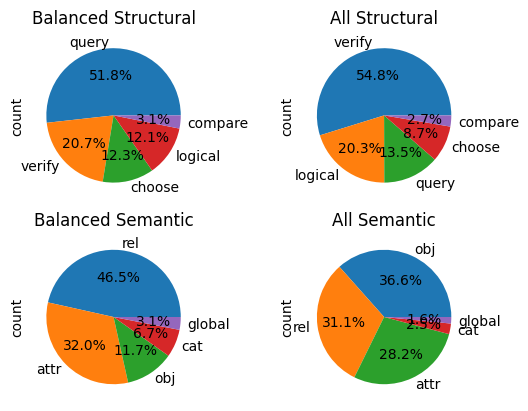

In [10]:
# visualize the type distributions
# with a 2x2 grid of pie charts, on the y-axis the type (structural, semantic) and on the x-axis the dataset (balanced, all)
fig, axs = plt.subplots(2, 2)

gqa_questions_balanced['structural_type'].value_counts().plot.pie(ax=axs[0,0],autopct='%1.1f%%')
axs[0,0].set_title('Balanced Structural')

gqa_questions_balanced['semantic_type'].value_counts().plot.pie(ax=axs[1,0],autopct='%1.1f%%')
axs[1,0].set_title('Balanced Semantic')

gqa_questions_all['structural_type'].value_counts().plot.pie(ax=axs[0,1],autopct='%1.1f%%')
axs[0,1].set_title('All Structural')

gqa_questions_all['semantic_type'].value_counts().plot.pie(ax=axs[1,1],autopct='%1.1f%%')
axs[1,1].set_title('All Semantic')

plt.show()

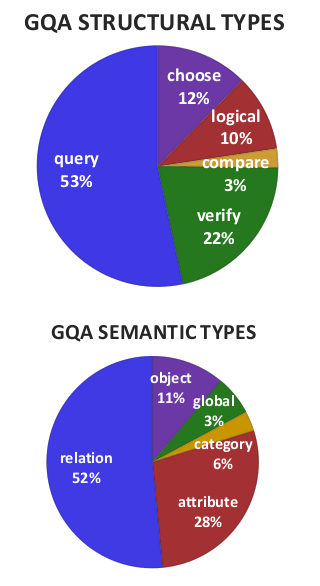

structural
* query: $51.7 \% != 53 \%$
* verify: $20.7 \% != 22 \%$
* logical: $12.1 \% != 10 \%$

semantic:
* relation: $46.6 \% != 52 \%$
* object: $11.8 \% != 11 \%$
* category: $6.7 \% != 6 \%$
* attribute: $31.9 \% != 28 \%$

Maybe it changes significantly if a different datasplit is used (only for balanced):

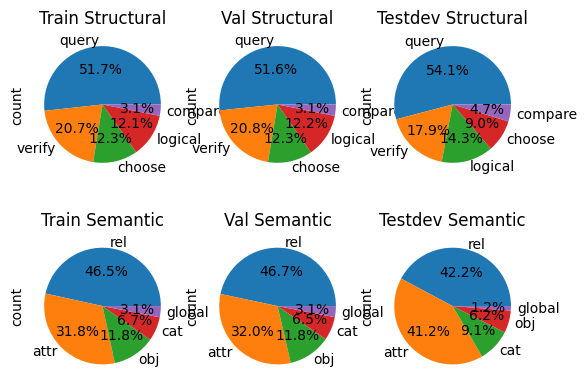

In [13]:
# visualize the type distributions, for balanced only
# with a 3x2 grid of pie charts, on the y-axis the type (structural, semantic) and on the x-axis the data split (train, val, testdev)
fig, axs = plt.subplots(2, 3)

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'train']['structural_type'].value_counts().plot.pie(ax=axs[0,0],autopct='%1.1f%%')
axs[0,0].set_title('Train Structural')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'train']['semantic_type'].value_counts().plot.pie(ax=axs[1,0],autopct='%1.1f%%')
axs[1,0].set_title('Train Semantic')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'val']['structural_type'].value_counts().plot.pie(ax=axs[0,1],autopct='%1.1f%%')
axs[0,1].set_title('Val Structural')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'val']['semantic_type'].value_counts().plot.pie(ax=axs[1,1],autopct='%1.1f%%')
axs[1,1].set_title('Val Semantic')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'testdev']['structural_type'].value_counts().plot.pie(ax=axs[0,2],autopct='%1.1f%%')
axs[0,2].set_title('Testdev Structural')

gqa_questions_balanced[gqa_questions_balanced['datasplit'] == 'testdev']['semantic_type'].value_counts().plot.pie(ax=axs[1,2],autopct='%1.1f%%')
axs[1,2].set_title('Testdev Semantic')

plt.show()

There seems to be quiet a bit of variance in it, but is it really enough to change the picture if the train data split has much more samples?

## Reproducing table 2: Function Catalog (ReadMe: 3.)

Here, probably the question as classified by its answer type is referenced?!

In [20]:
gqa_question_stats_table = gqa_question_stats[['detailed_type', 'semantic_type', 'structural_type']].drop_duplicates()
gqa_question_stats_table.sort_values(by='structural_type')

,detailed_type,semantic_type,structural_type
05168837,locationChoose,global,choose
16729733,categoryThatChoose,cat,choose
08480167,stateChoose,attr,choose
04874847,typeChoose,attr,choose
0574828,positionChoose,attr,choose
...,...,...,...
02140104,typeVerify,attr,verify
06883418,verifyAttrThis,attr,verify
0394253,verifyAttrCThis,attr,verify
05962433,weatherVerifyC,global,verify


This is also super different, they might have put some types together, but which ones? Looking below this is not trival to do for me...

In [21]:
gqa_question_stats_table[gqa_question_stats_table['structural_type'] == 'compare'].sort_values(by='semantic_type')

,detailed_type,semantic_type,structural_type
02212741,twoDifferentC,attr,compare
0172015,twoSame,attr,compare
03839467,diffAnimals,attr,compare
13761988,twoDifferent,attr,compare
15867119,sameAnimalsC,attr,compare
09330195,twoSameMaterialC,attr,compare
09680288,twoSameC,attr,compare
00226745,twoCommon,attr,compare
00299606,diffAnimalsC,attr,compare
051001757,sameAnimals,attr,compare


* they confused the table overline: `semantic` to `structural`!!
* where in the table is `compare` <-> `attr`? Where is `compare` to `object`?
* what does this type mean exactly? Only possible to understand it if going through the exact steps? But what does `detailed_type` mean in the dataset?

## Reproducing figure 10: Balancing the Dataset (ReadMe: 4.)

In [20]:
gqa_val_balanced_questions[list(set_val_balanced_questionIDs)[4]]

{'semantic': [{'operation': 'select',
   'dependencies': [],
   'argument': 'bowl (389375)'},
  {'operation': 'relate',
   'dependencies': [0],
   'argument': '_,under,s (1135742)'},
  {'operation': 'query', 'dependencies': [1], 'argument': 'name'}],
 'entailed': ['1231522', '1231524'],
 'equivalent': ['1231523'],
 'question': "What's under the bowl?",
 'imageId': '2402467',
 'isBalanced': True,
 'groups': {'global': 'thing', 'local': '14-bowl_under,s'},
 'answer': 'napkin',
 'semanticStr': 'select: bowl (389375)->relate: _,under,s (1135742) [0]->query: name [1]',
 'annotations': {'answer': {'0': '1135742'},
  'question': {},
  'fullAnswer': {'1': '1135742', '5': '389375'}},
 'types': {'detailed': 'relS', 'semantic': 'rel', 'structural': 'query'},
 'fullAnswer': 'The napkin is under the bowl.'}

In [21]:
# calculate the answer type with e.g. groups {'global': 'nature environment', 'local': '14-horse_running across,o'}
gqa_question_stats_raw = pd.concat([pd.DataFrame(gqa_train_balanced_questions).T, 
                                    pd.DataFrame(gqa_val_balanced_questions).T,
                                    pd.DataFrame(gqa_testdev_balanced_questions).T,])[['groups', 'answer', 'types']]
all_questionIDs = list(gqa_question_stats_raw.index)

answer_distribution_stats = pd.DataFrame(columns=['question_group', 'answer_type', 'answer_type_clean',
                                                  'answer_text'
                                                  'question_type_semantic', 'question_type_structural'],
                                        #  'answer_type_global_count','answer_type_local_count',
                                         index = all_questionIDs)

answer_distribution_stats.loc[slice(None),'answer_type_clean'] = gqa_question_stats_raw['groups'].apply(lambda x: x['local'].split('-')[-1].split(',')[0] if type(x['local']) is str else None)
answer_distribution_stats.loc[slice(None),'answer_text'] = gqa_question_stats_raw['answer']
answer_distribution_stats.loc[slice(None),'question_group'] = gqa_question_stats_raw['groups'].apply(lambda x: x['global'])
answer_distribution_stats.loc[slice(None),'answer_type'] = gqa_question_stats_raw['groups'].apply(lambda x: x['local'])
answer_distribution_stats.loc[slice(None),'question_type_semantic'] = gqa_question_stats_raw['types'].apply(lambda x: x['semantic'])
answer_distribution_stats.loc[slice(None),'question_type_structural'] = gqa_question_stats_raw['types'].apply(lambda x: x['structural'])

In [22]:
answer_distribution_stats

,question_group,answer_type,answer_type_clean,answer_textquestion_type_semantic,question_type_structural,answer_text,question_type_semantic
02930152,None,06-sky_dark,sky_dark,NaN,verify,yes,attr
07333408,,"14-wall_on,s",wall_on,NaN,query,pipe,rel
07333405,None,06-pipe_red,pipe_red,NaN,verify,no,attr
15736264,size,10c-clock_size,clock_size,NaN,choose,large,attr
111007521,person,"14-shirt_wearing,s",shirt_wearing,NaN,query,girl,rel
...,...,...,...,...,...,...,...
20341099,None,13-grass_fire hydrant,grass_fire hydrant,NaN,verify,yes,rel
20341098,plant,"14-fire hydrant_on,o",fire hydrant_on,NaN,query,grass,rel
20341097,plant,"14-fire hydrant_on,o",fire hydrant_on,NaN,query,grass,rel
20602949,nature environment,"14-horse_running across,o",horse_running across,NaN,query,ground,rel


In [23]:
question_group_set = answer_distribution_stats['question_group'].unique()
print(f"The question_group_set has {len(question_group_set)} unique values, e.g. {question_group_set[:10]}")

# remove None and the empty string, if applicable
question_group_set_clean = set([answer for answer in question_group_set if answer not in [None, '']])
print(f"The clean question_group_set has {len(question_group_set_clean)} unique values, e.g. {list(question_group_set_clean)[:10]}")

The question_group_set has 117 unique values, e.g. [None '' 'size' 'person' 'furniture' 'brightness' 'bird' 'material'
 'color' 'clothing']
The clean question_group_set has 115 unique values, e.g. ['gender', 'face expression', 'height', 'urban environment', 'flavor', 'length', '35', 'material', 'vegetable', 'shape']


In [24]:
# get the unique values for answer_type_global
answer_type_local_set = answer_distribution_stats['answer_type_clean'].unique()
print(f"The answer_type_local_set has {len(answer_type_local_set)} unique values, e.g. {answer_type_local_set[:10]}")

# remove None and the empty string, if applicable
answer_type_local_set_clean = set([answer for answer in answer_type_local_set if answer not in [None, '']])
print(f"The clean answer_type_local_set has {len(answer_type_local_set_clean)} unique values, e.g. {list(answer_type_local_set_clean)[:10]}")

The answer_type_local_set has 116145 unique values, e.g. ['sky_dark' 'wall_on' 'pipe_red' 'clock_size' 'shirt_wearing'
 'man_sleeping in' 'cheese_food' 'chair_to the right of' 'spatula_top'
 'man_woman']
The clean answer_type_local_set has 116144 unique values, e.g. ['person_reading', 'mirror_ceiling', 'bomb_waste basket', 'wine bottle_strawberry', 'container_red', 'bushes_tree leaves', 'cooker_standing in', 'carts_cigar', 'beach chair_child', 'letters_colorful']


In [12]:
selection_question_group_types = ['length', 'height', 'size', 'fast food', 'aircraft', 'bag', 'watercraft', 'person', 'room', 'weather', 'appliance', 'baked good',
                                    'thing', 'road', 'vehicle', 'fruit', 'place', 'dessert', 'urban environment', 'pose', 'furniture', 'activity', 'animal', 'food',
                                    'color', 'vegetable', 'material', 'clothing', 'device', 'object']
selection_local_answer_types = ['car_vposition', 'hair_length', 'location', 'girl_age', 'bottle_material', 'window_size', 'woman_hposition', 'grass_height', 
                                    'shirt_pattern', 'clock', 'floor_cleanliness', 'man', 'location_outdoors', 'car_modernity', 'plate_shape', 'sky_color', 'dog_color',
                                    'man_woman', 'water_state', 'table_material', 'apple_color', 'pizza_cooking', 'ground_type', 'fence_material', 'sky_weather',
                                    'man_sportActivity', 'shirt_color','trees_leafy', 'man_pose', 'man_activity']

In [26]:
# check whether the reported answer types are in the respective set
for answer in selection_question_group_types:
    if answer not in question_group_set_clean:
        print(f"{answer} is not in the global set")

for answer in selection_local_answer_types:
    if answer not in answer_type_local_set_clean:
        print(f"{answer} is not in the local set")
        partially = []
        part1, part2 = answer.split('_')
        for answer2 in answer_type_local_set_clean:
            part_2 = answer2.split('_')
            if len(part_2) >= 2:
                part1_2, part2_2 = part_2[0], part_2[1]
            else:
                part1_2, part2_2 = part_2[0], ""
            if answer in answer2:
                print(f"{answer} is in {answer2}")
            elif part1 == part1_2:
                partially.append(answer2)
            elif part2 == part2_2:
                partially.append(answer2)
        print(f"Partially: {partially}")

car_modernity is not in the local set
Partially: ['car_safety jacket', 'car_can', 'car_raincoat', 'car_waiting', 'car_letters', 'car_stuck in', 'car_tall', 'car_coin', 'car_field', 'car_jeep', 'car_windows', 'car_reflected on', 'car_little', 'car_paper dispenser', 'car_cone', 'car_coat', 'car_sitting inside', 'car_helmets', 'car_plier', 'car_walking by', 'car_jacket', 'car_tape', 'car_tank top', 'car_couches', 'car_around', 'car_fire hydrant', 'car_under', 'car_stove', 'car_figure', 'car_goat', 'car_lady', 'car_realism', 'car_castle', 'car_tree', 'car_wheelchair', 'car_long', 'car_bird', 'car_suit', 'car_cleanliness', 'car_factory', 'car_microphone', 'car_hill', 'car_kites', 'car_railroad', 'car_cds', 'car_dress shirt', 'car_ski', 'car_light bulbs', 'car_blue', 'car_trailer', 'car_minivan', 'car_shelves', 'car_box', 'car_woman', 'car_logo', 'car_covered', 'car_tie', 'car_waiting for', 'car_radio', 'car_dolls', 'car_baby', 'car_lying on top of', 'car_mannequins', 'car_mountain', 'car_ye

In [17]:
selection_local_answer_types.remove("ground_type")
selection_local_answer_types.remove("car_modernity")
selection_local_answer_types.append("car_modern")

This is strange... `car_modernity` -> `car_modern` probably though.

But let's see whether we can reproduce the figure... We show the top 10 answers for a selection of question groups, where the column height corresponds to the  relative frequency of each answer:

In [28]:
# do a stacked histogram: for each question group, plot the answer type distribution

question_group_distribution = pd.DataFrame(columns=['question_group', '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'],
                                           index = selection_question_group_types)
column_nos = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

for question_gr in selection_question_group_types:
    value_counts = answer_distribution_stats[answer_distribution_stats['question_group'] == question_gr]['answer_text'].value_counts()[:10]

    # normalize value counts
    value_counts = value_counts / value_counts.sum()

    # fill up the value counts with 0, if its shape is less than 10
    if len(value_counts) < 10:
        missing_values = pd.Series([0.] * (10 - len(value_counts)), index=[f'filler_{i+1}' for i in range(10 - len(value_counts))])
        value_counts = pd.concat([value_counts, missing_values])

    question_group_distribution.loc[question_gr, column_nos] = value_counts.values
    question_group_distribution.loc[question_gr, 'question_group'] = question_gr

question_group_distribution

,question_group,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
length,length,0.55914,0.44086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
height,height,0.503747,0.496253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
size,size,0.494956,0.452721,0.023279,0.013302,0.010309,0.005432,0.0,0.0,0.0,0.0
fast food,fast food,0.438384,0.322534,0.161575,0.036293,0.02276,0.010047,0.003896,0.003896,0.000615,0.0
aircraft,aircraft,0.432203,0.29661,0.160247,0.080123,0.030817,0.0,0.0,0.0,0.0,0.0
bag,bag,0.238636,0.206522,0.179348,0.142787,0.078557,0.055336,0.052372,0.035079,0.011364,0.0
watercraft,watercraft,0.311594,0.250906,0.185688,0.133152,0.099185,0.019475,0.0,0.0,0.0,0.0
person,person,0.249435,0.18451,0.140189,0.113304,0.072837,0.060923,0.055772,0.05353,0.05101,0.018492
room,room,0.256872,0.247876,0.178411,0.171414,0.112944,0.027486,0.004998,0.0,0.0,0.0
weather,weather,0.257738,0.196778,0.190145,0.159191,0.058433,0.055591,0.043588,0.020846,0.017688,0.0


In [32]:
# question_group_distribution.reset_index(inplace=True)
question_group_distribution.sort_values(by='1st', ascending=False, inplace=True)
question_group_distribution.reset_index(drop=True, inplace=True)
question_group_distribution

,question_group,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,length,0.55914,0.44086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,height,0.503747,0.496253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,size,0.494956,0.452721,0.023279,0.013302,0.010309,0.005432,0.0,0.0,0.0,0.0
3,fast food,0.438384,0.322534,0.161575,0.036293,0.02276,0.010047,0.003896,0.003896,0.000615,0.0
4,aircraft,0.432203,0.29661,0.160247,0.080123,0.030817,0.0,0.0,0.0,0.0,0.0
5,watercraft,0.311594,0.250906,0.185688,0.133152,0.099185,0.019475,0.0,0.0,0.0,0.0
6,road,0.260852,0.216622,0.163958,0.096688,0.085579,0.078996,0.034149,0.029624,0.020983,0.012549
7,weather,0.257738,0.196778,0.190145,0.159191,0.058433,0.055591,0.043588,0.020846,0.017688,0.0
8,room,0.256872,0.247876,0.178411,0.171414,0.112944,0.027486,0.004998,0.0,0.0,0.0
9,baked good,0.25659,0.214602,0.143224,0.132727,0.091672,0.056916,0.037089,0.031957,0.021693,0.013529


In [45]:
question_group_distribution_long = pd.melt(question_group_distribution, id_vars='question_group', value_vars=column_nos, var_name='Rank', value_name='Relative Frequency')

fig = px.bar(question_group_distribution_long, x="question_group", y="Relative Frequency", color='Rank', 
             title="Figure 2 top right")
fig.write_html("results/question_type_bal.html")

NameError: name 'question_group_distribution' is not defined

`bag` (6 -> 16) is somewhere totally different, a lot of others where also changing places... `fast food` and `aircraft` are now basically on the same most frequent levels. (...) but the general picture is similar.

In [44]:
# do a stacked histogram: for each answer group, plot the answer type distribution

answer_group_distribution = pd.DataFrame(columns=['answer_group', '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'],
                                           index = selection_local_answer_types)
column_nos = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

for answer_gr in selection_local_answer_types:
    value_counts = answer_distribution_stats[answer_distribution_stats['answer_type_clean'] == answer_gr]['answer_text'].value_counts()[:10]

    # normalize value counts
    value_counts = value_counts / value_counts.sum()

    # fill up the value counts with 0, if its shape is less than 10
    if len(value_counts) < 10:
        missing_values = pd.Series([0.] * (10 - len(value_counts)), index=[f'filler_{i+1}' for i in range(10 - len(value_counts))])
        value_counts = pd.concat([value_counts, missing_values])

    answer_group_distribution.loc[answer_gr, column_nos] = value_counts.values
    answer_group_distribution.loc[answer_gr, 'answer_group'] = answer_gr

answer_group_distribution.reset_index(drop=True, inplace=True)
answer_group_distribution.sort_values(by='1st', ascending=False, inplace=True)
answer_group_distribution_long = pd.melt(answer_group_distribution, id_vars='answer_group', value_vars=column_nos, var_name='Rank', value_name='Relative Frequency')

answer_group_distribution

,answer_group,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
28,car_modern,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,man,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,floor_cleanliness,0.638655,0.319328,0.042017,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,girl_age,0.573427,0.405594,0.013986,0.006993,0.0,0.0,0.0,0.0,0.0,0.0
0,car_vposition,0.559598,0.440402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,hair_length,0.558239,0.441761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,shirt_pattern,0.556,0.412,0.032,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,trees_leafy,0.555556,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,location,0.554244,0.445756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,window_size,0.548193,0.427711,0.01506,0.006024,0.003012,0.0,0.0,0.0,0.0,0.0


In [42]:
fig = px.bar(answer_group_distribution_long, x="answer_group", y="Relative Frequency", color='Rank', 
             title="Figure 2 bottom right")
fig.write_html("results/answer_type_bal.html")

NameError: name 'answer_group_distribution_long' is not defined

Vastly different!

### Unbalanced Distribution



In [8]:
# load all questions
gqa_data_path = Path('local_datasets/GQA')

gqa_train_all_questions_file_paths = [file for file in Path(gqa_data_path / 'train_all_questions').glob('*.json')]
gqa_train_all_questions = pd.DataFrame(json.load(open(gqa_train_all_questions_file_paths[0]))).T
for file in gqa_train_all_questions_file_paths[1:]:
    gqa_train_all_questions = pd.concat([gqa_train_all_questions, pd.DataFrame(json.load(open(file))).T])

In [33]:
gqa_val_all_questions = json.load(open(Path(gqa_data_path / ('val_' + 'all_' + 'questions.json'))))
gqa_val_all_questions = pd.DataFrame(gqa_val_all_questions).T
gqa_testdev_all_questions = json.load(open(Path(gqa_data_path / ('testdev_' + 'all_' + 'questions.json'))))
gqa_testdev_all_questions = pd.DataFrame(gqa_testdev_all_questions).T

In [9]:
gqa_train_all_questions

,semantic,entailed,equivalent,question,imageId,isBalanced,groups,answer,semanticStr,annotations,types,fullAnswer
08519876,"[{'operation': 'select', 'dependencies': [], '...",[08519877],[08519876],Is there a chair that is tan in this scene?,2317174,False,"{'global': None, 'local': '04-chair_tan'}",no,select: chair (1023076)->filter color: tan [0]...,"{'answer': {}, 'question': {'3': '1023076'}, '...","{'detailed': 'existAttrC', 'semantic': 'obj', ...","No, there is a chair but it is red."
08519877,"[{'operation': 'select', 'dependencies': [], '...",[08519876],[08519877],Are there chairs in the photograph that are tan?,2317174,False,"{'global': None, 'local': '04-chair_tan'}",no,select: chair (1023076)->filter color: tan [0]...,"{'answer': {}, 'question': {'2': '1023076'}, '...","{'detailed': 'existThatC', 'semantic': 'obj', ...","No, there is a chair but it is red."
08519870,"[{'operation': 'select', 'dependencies': [], '...","[08519869, 08519868, 08519880, 08519872, 08519...",[08519870],Does the chair to the left of the person look ...,2317174,False,"{'global': None, 'local': '06-chair_red'}",yes,"select: person (1023068)->relate: chair,to the...","{'answer': {}, 'question': {'8': '1023068', '2...","{'detailed': 'verifyAttrK', 'semantic': 'attr'...","Yes, the chair is red."
08519871,"[{'operation': 'select', 'dependencies': [], '...","[08519869, 08519868, 08519880, 08519872, 08519...",[08519871],Which color is the chair?,2317174,False,"{'global': 'color', 'local': '10q-chair_color'}",red,select: chair (1023076)->query: color [0],"{'answer': {}, 'question': {'4': '1023076'}, '...","{'detailed': 'directWhich', 'semantic': 'attr'...",The chair is red.
08519872,"[{'operation': 'select', 'dependencies': [], '...","[08519873, 08519874]","[08519872, 08519873]",Is the chair beige?,2317174,False,"{'global': None, 'local': '06-chair_beige'}",no,select: chair (1023076)->verify color: beige [0],"{'answer': {}, 'question': {'2': '1023076'}, '...","{'detailed': 'verifyAttrC', 'semantic': 'attr'...","No, the chair is red."
...,...,...,...,...,...,...,...,...,...,...,...,...
0782527,"[{'operation': 'select', 'dependencies': [], '...",[0782511],[0782527],Do you see a child to the right of the blue bear?,2377146,False,"{'global': None, 'local': '13-bear_child'}",yes,select: bear (1905940)->filter color: blue [0]...,"{'answer': {}, 'question': {'4': '3680134', '1...","{'detailed': 'existRelS', 'semantic': 'rel', '...","Yes, there is a child to the right of the bear."
0782526,"[{'operation': 'select', 'dependencies': [], '...",[],[0782526],Do you see a chair to the left of the person w...,2377146,False,"{'global': None, 'local': '13-person_chair'}",no,"select: hat (2630185)->relate: person,wearing,...","{'answer': {}, 'question': {'10': '2630184', '...","{'detailed': 'existRelSC', 'semantic': 'rel', ...","No, there is a child to the left of the person."
0782525,"[{'operation': 'select', 'dependencies': [], '...",[0782524],"[0782524, 0782525]",Do you see a child to the right of the person ...,2377146,False,"{'global': None, 'local': '13-person_child'}",no,"select: hat (2630185)->relate: person,wearing,...","{'answer': {}, 'question': {'10': '2630184', '...","{'detailed': 'existRelSRC', 'semantic': 'rel',...","No, the child is to the left of the person."
0782524,"[{'operation': 'select', 'dependencies': [], '...",[0782525],"[0782524, 0782525]",Is there a child to the right of the person th...,2377146,False,"{'global': None, 'local': '13-person_child'}",no,"select: hat (2630185)->relate: person,wearing,...","{'answer': {}, 'question': {'9': '2630184', '3...","{'detailed': 'existRelSRC', 'semantic': 'rel',...","No, the child is to the left of the person."


In [35]:
gqa_question_stats_raw_all = pd.concat([gqa_train_all_questions, 
                                        gqa_val_all_questions,
                                        gqa_testdev_all_questions,])[['groups', 'answer', 'types']]
all_questionIDs_all = list(gqa_question_stats_raw_all.index)

answer_distribution_stats_all = pd.DataFrame(columns=['question_group', 'answer_type', 'answer_type_clean',
                                                      'answer_text'
                                                      'question_type_semantic', 'question_type_structural'],
                                                      #  'answer_type_global_count','answer_type_local_count',
                                                      index = all_questionIDs_all)

answer_distribution_stats_all.loc[list(gqa_train_all_questions.index), 'datasplit'] = 'train'
answer_distribution_stats_all.loc[list(gqa_val_all_questions.index), 'datasplit'] = 'val'
answer_distribution_stats_all.loc[list(gqa_testdev_all_questions.index), 'datasplit'] = 'testdev'

answer_distribution_stats_all.loc[slice(None),'answer_type_clean'] = gqa_question_stats_raw_all['groups'].apply(lambda x: x['local'].split('-')[-1].split(',')[0] if type(x['local']) is str else None)
answer_distribution_stats_all.loc[slice(None),'answer_text'] = gqa_question_stats_raw_all['answer']
answer_distribution_stats_all.loc[slice(None),'question_group'] = gqa_question_stats_raw_all['groups'].apply(lambda x: x['global'])
answer_distribution_stats_all.loc[slice(None),'answer_type'] = gqa_question_stats_raw_all['groups'].apply(lambda x: x['local'])
answer_distribution_stats_all.loc[slice(None),'question_type_semantic'] = gqa_question_stats_raw_all['types'].apply(lambda x: x['semantic'])
answer_distribution_stats_all.loc[slice(None),'question_type_structural'] = gqa_question_stats_raw_all['types'].apply(lambda x: x['structural'])

In [13]:
# do a stacked histogram: for each question group, plot the answer type distribution

question_group_distribution_all = pd.DataFrame(columns=['question_group', '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'],
                                           index = selection_question_group_types)
column_nos = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

for question_gr in selection_question_group_types:
    value_counts = answer_distribution_stats_all[answer_distribution_stats_all['question_group'] == question_gr]['answer_text'].value_counts()[:10]

    # normalize value counts
    value_counts = value_counts / value_counts.sum()

    # fill up the value counts with 0, if its shape is less than 10
    if len(value_counts) < 10:
        missing_values = pd.Series([0.] * (10 - len(value_counts)), index=[f'filler_{i+1}' for i in range(10 - len(value_counts))])
        value_counts = pd.concat([value_counts, missing_values])

    question_group_distribution_all.loc[question_gr, column_nos] = value_counts.values
    question_group_distribution_all.loc[question_gr, 'question_group'] = question_gr

question_group_distribution_all.sort_values(by='1st', ascending=False, inplace=True)
question_group_distribution_all.reset_index(drop=True, inplace=True)

question_group_distribution_all

,question_group,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,aircraft,0.898679,0.063641,0.02339,0.011926,0.002365,0.0,0.0,0.0,0.0,0.0
1,watercraft,0.836422,0.058497,0.048213,0.027645,0.02459,0.004633,0.0,0.0,0.0,0.0
2,dessert,0.800217,0.059323,0.05575,0.029151,0.016457,0.012949,0.007017,0.006889,0.006698,0.00555
3,length,0.780062,0.219938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,height,0.759491,0.240509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,fast food,0.751309,0.152975,0.066903,0.014207,0.007257,0.004042,0.001776,0.001194,0.000337,0.0
6,size,0.543145,0.4273,0.011051,0.009706,0.005984,0.002815,0.0,0.0,0.0,0.0
7,urban environment,0.53899,0.191154,0.119936,0.043763,0.036177,0.024307,0.023585,0.007741,0.007173,0.007173
8,weather,0.524002,0.200953,0.094223,0.091682,0.048243,0.016597,0.012071,0.006432,0.005797,0.0
9,person,0.500159,0.197838,0.088709,0.061668,0.037093,0.030216,0.029074,0.024602,0.0209,0.009741


In [43]:
question_group_distribution_long_all = pd.melt(question_group_distribution_all, id_vars='question_group', value_vars=column_nos, var_name='Rank', value_name='Relative Frequency')

fig = px.bar(question_group_distribution_long_all, x="question_group", y="Relative Frequency", color='Rank', 
             title="Figure 2 top right")
fig.write_html("results/question_type_all.html")

`material` nearly perfectly switched with `clothing`, `applicance` with `vehicle`.

In [18]:
# do a stacked histogram: for each answer group, plot the answer type distribution

answer_group_distribution_all = pd.DataFrame(columns=['answer_group', '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'],
                                           index = selection_local_answer_types)
column_nos = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

for answer_gr in selection_local_answer_types:
    value_counts = answer_distribution_stats_all[answer_distribution_stats_all['answer_type_clean'] == answer_gr]['answer_text'].value_counts()[:10]

    # normalize value counts
    value_counts = value_counts / value_counts.sum()

    # fill up the value counts with 0, if its shape is less than 10
    if len(value_counts) < 10:
        missing_values = pd.Series([0.] * (10 - len(value_counts)), index=[f'filler_{i+1}' for i in range(10 - len(value_counts))])
        value_counts = pd.concat([value_counts, missing_values])

    answer_group_distribution_all.loc[answer_gr, column_nos] = value_counts.values
    answer_group_distribution_all.loc[answer_gr, 'answer_group'] = answer_gr

answer_group_distribution_all.reset_index(drop=True, inplace=True)
answer_group_distribution_all.sort_values(by='1st', ascending=False, inplace=True)
answer_group_distribution_long_all = pd.melt(answer_group_distribution_all, id_vars='answer_group', value_vars=column_nos, var_name='Rank', value_name='Relative Frequency')

answer_group_distribution_all

,answer_group,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
11,man,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,car_modern,0.952381,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,shirt_pattern,0.873724,0.116497,0.009779,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,clock,0.851224,0.148776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,plate_shape,0.830649,0.129299,0.036569,0.003483,0.0,0.0,0.0,0.0,0.0,0.0
20,pizza_cooking,0.830189,0.113208,0.037736,0.018868,0.0,0.0,0.0,0.0,0.0,0.0
12,location_outdoors,0.806546,0.193454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,location,0.806086,0.193914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,table_material,0.796841,0.108965,0.038859,0.026815,0.011817,0.006817,0.004318,0.0025,0.001818,0.00125
14,sky_color,0.765891,0.111868,0.06293,0.032083,0.009016,0.00585,0.004433,0.003769,0.002322,0.001839


In [44]:
fig = px.bar(answer_group_distribution_long_all, x="answer_group", y="Relative Frequency", color='Rank', 
             title="Figure 2 bottom right")
fig.write_html("results/answer_type_all.html")

Vastly different for `man`, `car_modern`, and a lot of other labels.

In [36]:
answer_distribution_stats_all[answer_distribution_stats_all['answer_type_clean'] == "man"]


,question_group,answer_type,answer_type_clean,answer_textquestion_type_semantic,question_type_structural,datasplit,answer_text,question_type_semantic
11458330,None,03-man,man,NaN,verify,train,no,obj
0641014,None,03-man,man,NaN,verify,train,no,obj
17861074,None,03-man,man,NaN,verify,train,no,obj
18738432,None,03-man,man,NaN,verify,train,no,obj
06203494,None,03-man,man,NaN,verify,train,no,obj
...,...,...,...,...,...,...,...,...
201739243,None,03-man,man,NaN,verify,testdev,no,obj
201979175,None,03-man,man,NaN,verify,testdev,no,obj
201896347,None,03-man,man,NaN,verify,testdev,no,obj
20204919,None,03-man,man,NaN,verify,testdev,no,obj


In [41]:
len(answer_distribution_stats_all['answer_type_clean'].unique())

265580

## Reproducing figure 13: Semantic Composition Length (ReadMe: 5.)

In [ ]:
# make a pie-plot of composition_len_semantic, but summarize all values above 4
gqa_question_stats_pie = gqa_question_stats['composition_len_semantic']
gqa_question_stats_pie[gqa_question_stats_pie >= 4] = 4

gqa_question_stats_pie.value_counts().plot.pie(autopct='%1.1f%%')

In [ ]:
# make a pie diagram with all values of detailed_type in gqa_question_stats with plotly and interactive
fig = px.pie(gqa_question_stats, names='detailed_type')

# the legend should only show the first 20 entries and be on the left
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(showlegend=False, legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig.write_html('results/detailed_type_pie.html')

## Reproducing table 3: Comparison of VQA and GQA (ReadMe: 6.)

In [ ]:
# caluclate the mean length and std of the questions
mean_length = gqa_question_stats['question_length'].mean()
mean_length_wo_test = gqa_question_stats[gqa_question_stats['datasplit'] != 'testdev']['question_length'].mean()
std_length = gqa_question_stats['question_length'].std()
std_length_wo_test = gqa_question_stats[gqa_question_stats['datasplit'] != 'testdev']['question_length'].std()
print(f"Question length: {mean_length:.2f} +/- {std_length:.2f}")
print(f"Question length (without testdev): {mean_length_wo_test:.2f} +/- {std_length_wo_test:.2f}")

# calculate the ratio of the where-questions and the who-questions
where_questions = gqa_question_stats['question_text'].apply(lambda x: True if 'where' in x.lower().split()[0] else False)
print(f"The ratio of where-questions is {where_questions.sum() / len(where_questions):.3f}")
who_questions = gqa_question_stats['question_text'].apply(lambda x: True if 'who' in x.lower().split()[0] else False)
print(f"The ratio of who-questions is {who_questions.sum() / len(who_questions):.3f}")

print(f"Short Questions <= 5 words: {len(gqa_question_stats[gqa_question_stats['question_length'] <= 5]) / len(gqa_question_stats):.2f}")
print(f"Compositional Questions (>0): {len(gqa_question_stats[gqa_question_stats['composition_len_semantic'] > 0]) / len(gqa_question_stats):.2f}")
print(f"Compositional Questions (>1): {len(gqa_question_stats[gqa_question_stats['composition_len_semantic'] > 1]) / len(gqa_question_stats):.2f}")
print(f"Composition length: {gqa_question_stats['composition_len_semantic'].mean():.2f} +/- {gqa_question_stats['composition_len_semantic'].std():.2f}")

# calculate the ratio of relation, spatial, logical, comparative
gqa_question_stats['structural_type'].value_counts(normalize=True)

* the question length and the std is quiet different!
* the percentage of short questions is slightly different
* how does calculating compositional questions work?
* Spatial == `verify`?
* less `logical` found

In [ ]:
# make a counter of the objects, categories, attributes and relations (excluding left/right (500k occurrences, inferred automatically rather than being hand-annotated as all other relations)
# TODO!

# visualize the number of occurrences of the objects, categories, attributes and relations
# TODO!